# Simulating Gravity with Graph Neural Networks

### by Petja Furlan and Lazar Đoković
### Mentor: Lovro Šubelj

In this notebook, we will present the code used in our Medium blog post *[Simulating Gravity with Graph Neural Networks](https://medium.com/@petjafurlan/simulating-gravity-with-graph-neural-networks-d3be57abf60f)*. The code was developed as part of the Machine learning with graphs course offered at the University of Ljubljana, Faculty of Computer and Information science.

Let's start with a quick recap of the model we developed based on our findings:

### GraviNet

*GraviNet* is an ensemble model used for learning rotational gravitational effects exhibited by planets orbiting stars. It combines (parellel) results from multiple heterogeneous models and aggregates them to get the final result. Each model is fed the node embeddings of the entire system at time *t* and outputs the velocities at time *t + 1*. We represent each system as a fully connected graph, where each node is an object and edges represent gravitational dependencies. 

The node embeddigs are characterized by planet feature vectors. These consist of:

1. Mass
2. Position
3. Velocity

where Position and Velocity can have either 2 or 3 components based on the simulation type (whether it is 2D or 3D). The simulation we will present will be a 2D simulation, where each body feature vector will be of the form $[m, x_1, x_2, v_1, v_2]^T$.

The aggregation used to combine all of the outputs is a linear combination that is also learned.

The choice of the number and type of models used within the GraviNet network is highly dependant on the type of simulation we would wish to learn. Therefore, the torch module is written in a modular fashion, allowing quick redefinitions of model types and counts via the arguments passed at module creation.

The models we have decided to include in the GraviNet architecture are the following:

1. InteractionGraphNetwork (IGN)
2. Graph Isomorphism Network (GIN)
3. Graph Convolutional Network (GCN)
4. Multilayer Perceptron (MLP)

where IGN is a second model we developed for learning rotational gravitational effects. More word on that soon.

Our motivation for including these specific models is as follow:

- We found that the IGN model was capable of learning only one rotational direction, which means that it can not simulate two bodies orbiting a star in different directions. Having a sum of two weighted IGNs enabled GraviNet to learn both rotations. Therefore, we recomend to have as many IGNs as there are distinct orbits.
- GIN and GCN were added to capture interactions between systems with a greater number of moving objects. Their inclusions however, usually resulted in worse simulations so we recommend adding them only if IGNs and MLPs dont work.
- MLPs were added to capture complex translational movements of entire system, i.e. a star system drifting in a certain direction.

A scheme of the GraviNet architecture is shown below:

<figure>
  <center>
  <img src="diagrams\GraviNet\GraviNetImg.jpg" alt="GraviNet Arch"	width="752" height="445"/>
  <figcaption>Fig. 1 - GraviNet Architecture.</figcaption>
  </center>
</figure>

### InteractionGraphNetwork

A key component of our GraviNet model is the *InteractionGraphNetwork* (IGN) GNN. Here we will quickly present its architecture too.

Our research found that regular graph neural networks like GCN, GAT and GIN are not able to learn rotation. For this reason, we spent a lot of time developing a model that would be powerful enough to learn this complex movement. Eventually, we developed a model inspired by the paper *[Interaction Networks for Learning about Objects,
Relations and Physics](https://arxiv.org/pdf/1612.00222.pdf)*.

InteractionGraphNetwork consists of:

1. A four layer Linear encoder (MLP) module with hidden layer dimensions of length 150. Each layer except for the last is followed by a *Parametric Rectified Linear Unit* (PReLU) while the last layer is followed by a *Tanh* non-linearity. IGNs input is first passed to this encoder.
2. A three layer GIN network with adjustable hidden layer size (GIN preformed the best in our empiric testing). The encoder output is passed to the GNN as input.
3. A two layer Linear decoder (MLP) module with a single Tanh non-linearity in between the layers. The GNN output is concatenated with the original input to the IGN (with a skip-connection) and passed to the decoder.

Interestingly, the key to learning rotation turned out to be the skip-connection. We theorize that this is due to the algorithmic alignment of this model to the problem at hand.

A scheme of the InteractionGraphNetwork architecture is shown below:

<figure>
  <center>
  <img src="diagrams\IN\IN.jpg" alt="IGN Arch"	width="400" height="500"/>
  <figcaption>Fig. 2 - IGN Architecture.</figcaption>
  </center>
</figure>

### GraviNet speed and data shape

One of the goals when designing our network was to keep it as GPU frendly as possible. Doing calculations on the graphics card makes the training process a lot quicker.

This was made easier by the fact that certain pytorch_geometric models support message passing in *statics graphs*. This means that we can pass the network a input feature tensor of the form *[batch_size, num_nodes, input_dim]* and a single edge index and it will calculate the result for each batch seperately, using the same edge index for every *graph* in the batch. This makes traning faster since there is no need to iterate though the batch with a for-loop and the entire computation is done with tensor operations. 

For this reason, GraviNet accepts *either* a input tensor of shape *[batch_size, num_nodes, input_dim]* or *[num_nodes, input_dim]*. This makes training more effieicent. GraviNet then outputs either *[batch_size, num_nodes, d]* or *[num_nodes, d]* (*d* is 2 for 2D and 3 for 3D simulations) sized tensors that represent velocities in the next time step.

You can find a list of pytorch_geometric networks that support static graphs *[here](https://pytorch-geometric.readthedocs.io/en/latest/notes/cheatsheet.html)*.

### Setup

First we need to import all of the libraries used in this notebook.

In [14]:
import torch
import random
import numpy as np
import torch.nn as nn
from drawer import PygApp
from copy import deepcopy
from torch.autograd import Variable
from simulator import make_dataset
from matplotlib import pyplot as plt
from torch_geometric.nn.models import GCN, GIN
from simulator import FiveStars

### Models

We also define a generic MLP class.

In [15]:
class MLP(nn.Module):
    """
    A generic MLP class.
    """
    def __init__(self, layers, act):
        """
        Arguments
        ---------
        layer_sizes : list
            A list of layer dimensions. The MLP will have len(layers) - 1 layers.
        hidden_dim : int
            Hidden layer dimension
        output_dim : int
            Output layer dimension
        """
        super(MLP, self).__init__()

        layers = [nn.Linear(input_dim, output_dim) for input_dim, output_dim in zip(layers, layers[1:])]
        self.layers = nn.ModuleList(layers)
        self.act = act

    def forward(self, x):
        """
        Arguments
        ---------
        x : Tensor
            Input feature tensor of size [batch_size x num_bodies x input_dim] or [num_bodies x input_dim]

        Returns
        -------
        out : Tensor
            Output feature tensor of size [batch_size x num_bodies x output_dim] or [num_bodies x output_dim]
        """
        for layer in self.layers[:-1]:
            x = self.act(layer(x))
        out = self.layers[-1](x)
        return out

Now we will define the Encoder module described in the introduction. Be mindful of the Tanh placement when implementing this class yourselves.

In [16]:
class Encoder(nn.Module):
    """
    Encoder class that represent a preprocessing MLP with 4 Linear layers
    with PReLUs, followed by a tanh non-linearity.
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Arguments
        ---------
        input_dim : int
            Feature vector dimension
        hidden_dim : int
            Hidden layer dimension
        output_dim : int
            Output layer dimension
        """
        super(Encoder, self).__init__()
        self.output_dim = output_dim
        
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.PReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.PReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.PReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh()
        )
    
    def forward(self, x):
        """
        Arguments
        ---------
        x : Tensor
            Input feature tensor of size [batch_size x num_bodies x input_dim] or [num_bodies x input_dim]

        Returns
        -------
        out : Tensor
            Output feature tensor of size [batch_size x num_bodies x output_dim] or [num_bodies x output_dim]
        """
        if len(x.shape) == 2: return self.layers(x)
        batch_size, num_bodies, input_dim = x.size()
        x = x.view(-1, input_dim)
        x = self.layers(x)
        out = x.view(batch_size, num_bodies, self.output_dim)
        return out

We will also define the Decoder module, as described above.

In [17]:
class Decoder(nn.Module):
    """
    Decoder class that represent a postprocessing MLP with 2 Linear layers
    and a single tanh non-linearity placed after the first layer.
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Arguments
        ---------
        input_dim : int
            Feature vector dimension
        hidden_dim : int
            Hidden layer dimension
        output_dim : int
            Output layer dimension
        """
        super(Decoder, self).__init__()
        self.output_dim = output_dim
        
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        """
        Arguments
        ---------
        x : Tensor
            Input feature tensor of size [batch_size x num_bodies x input_dim] or [num_bodies x input_dim]

        Returns
        -------
        out : Tensor
            Output feature tensor of size [batch_size x num_bodies x output_dim] or [num_bodies x output_dim]
        """
        if len(x.shape) == 2: return self.layers(x)
        batch_size, num_bodies, input_dim = x.size()
        x = x.view(-1, input_dim)
        x = self.layers(x)
        out = x.view(batch_size, num_bodies, self.output_dim)
        return out

The InteractionGraphNetwork is a GNN with the Encoder and Decoder modules previously defined.

In [18]:
class InteractionGraphNetwork(nn.Module):
    """
    InteractionGraphNetwork class that combines pre and postprocessing MLPs with 
    GIN (a Graph Neural Network) to create a pytorch module capable of learning 
    rotation.
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Arguments
        ---------
        input_dim : int
            Feature vector dimension
        hidden_dim : int
            Hidden layer dimension
        output_dim : int
            Output layer dimension
        """
        super(InteractionGraphNetwork, self).__init__()
        
        self.relational_model = Encoder(input_dim, 150, hidden_dim)

        self.gnn = GIN(hidden_dim, hidden_dim, 3, hidden_dim)

        self.object_model = Decoder(input_dim + hidden_dim, 100, output_dim)

        self.batch_norm = nn.BatchNorm1d(input_dim)
    
    def forward(self, x, edge_index):
        """
        Arguments
        ---------
        x : Tensor
            Input feature tensor of size [batch_size x num_bodies x input_dim] or [num_bodies x input_dim]
        edge_index : LongTensor
            Graph connectivity in COO format with shape [2, num_edges]

        Returns
        -------
        out : Tensor
            Output feature tensor of size [batch_size x num_bodies x output_dim] or [num_bodies x output_dim]
        """
        # objects = torch.transpose(self.batch_norm(torch.transpose(objects, 1, 2)), 1, 2)
        effects = self.relational_model(x)
        effects = self.gnn(effects, edge_index)
        out = self.object_model(torch.cat([x, effects], 1)) if len(x.shape) == 2 else self.object_model(torch.cat([x, effects], 2))
        return out

Lastly, we define the GraviNet module, which is a ensemble of various kinds of models, with the IGN at its heart.

In [19]:
class GraviNet(nn.Module):
    """
    GraviNet class that combines multiple parallel InteractionGraphNetworks, GNNs and MLPs that
    can learn more complex rotations and translations. It combines the results of all 
    the networks with a weighted sum of the outputs.
    """
    def __init__(self, object_count, input_dim, hidden_dim, output_dim, int_net_count, gin_count, gcn_count, mlp_count):
        """
        Arguments
        ---------
        object_count : int
            Number of bodies to simulate
        input_dim : int
            Feature vector dimension
        hidden_dim : int
            Hidden layer dimension
        output_dim : int
            Output layer dimension
        int_net_count : int
            Number of parallel InteractionGraphNetwork
        gin_count : int
            Number of parallel GINs
        gcn_count : int
            Number of parallel GCNs
        mlp_count : int
            Number of parallel MLPs
        """
        super(GraviNet, self).__init__()
        
        self.ign = nn.ModuleList([InteractionGraphNetwork(input_dim, hidden_dim, output_dim) for _ in range(int_net_count)])

        self.gin = nn.ModuleList([GIN(input_dim, hidden_dim, 2, output_dim) for _ in range(gin_count)])

        self.gcn = nn.ModuleList([GCN(input_dim, hidden_dim, 2, output_dim) for _ in range(gcn_count)])

        self.mlp = nn.ModuleList([MLP([input_dim, hidden_dim, hidden_dim, output_dim], nn.PReLU()) for _ in range(mlp_count)])

        self.num_models = int_net_count + gin_count + gcn_count + mlp_count

        self.weights = nn.ParameterList([nn.Parameter(torch.rand((object_count, 1))) for _ in range(self.num_models)])

    def forward(self, x, edge_index):
        """
        Arguments
        ---------
        x : Tensor
            Input feature tensor of size [batch_size x num_bodies x input_dim] or [num_bodies x input_dim]
        edge_index : LongTensor
            Graph connectivity in COO format with shape [2, num_edges]

        Returns
        -------
        out : Tensor
            Output feature tensor of size [batch_size x num_bodies x output_dim] or [num_bodies x output_dim]
        """
        outputs = []
        models = self.ign + self.gin + self.gcn + self.mlp
        for i in range(self.num_models):
            model = models[i]
            weight = self.weights[i]
            emb = model(x) if isinstance(model, MLP) else model(x, edge_index)
            outputs.append(emb*weight)
        
        out = torch.stack(outputs).sum(dim=0)

        return out

### Training

For reproducibility purposes, we will set the random seeds in all of the modules we will use. We will also set the device to 'cuda', if a NVIDIA graphics card is available for use. 

In [20]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

device = None
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

Additionally, we define two functions that will help us visualise the model's traning loss and error rates.

In [21]:
def plot_loss(losses):
    """
    A function to plot the training loss of a GNN.

    Arguments
    ---------
    losses : list
        A list of all of the losses during training
    """
    plt.plot(losses)
    plt.title("GraviNet MSE Loss", fontdict = {'size':20})
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

def plot_error(errors):
    """
    A function to plot the training errors of a GNN.

    Arguments
    ---------
    errors : list
        A list of all of the errors during training
    """
    plt.plot(errors)
    plt.title("GraviNet Error", fontdict = {'size':20})
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.show()

The next two functions are key to the successful traning of our model.

First we will define the create_dataset function. This is a wrapper function that we can pass a description of a *system* and it will call our RK4 simulator (with step size *dt*) to create a dataset of size *timesteps*. It will create a tensor *dataset* of shape *[timesteps x num_bodies x body_features]*, send it to *device* and return it.
Additionally, it will also add some gaussian noise to make overfitting less likely.

As mentioned in the introduction, each body in 2D has features $[m, x_1, x_2, v_1, v_2]^T$.

The second function we will define, is a batching function that will randomly sample time steps from *dataset* to create a batch of shape *[batch_size x num_bodies x body_features]*. Here, *batch_size* must be less than *timesteps*.

It will return this tensor along with the ground truth. The ground truth is a tensor with the same dimensions. However, for each index corresponding to a time step in the batch, this tensor stores the speed of the succeeding time step from that particular index.

In [22]:
def create_dataset(system, timesteps, dt, device):
    """
    A function that uses our own RK4-based simulator to create a dataset on which a GNN can train.
    It also adds some random noise to the dataset to reduce network overfitting.

    Arguments
    ---------
    system : dict
        A dictionary that represents the description of the simulated system
    timesteps : int
        Number of time steps to simulate
    dt : float
        The step size used in the RK4 method
    device : str
        The device to which to send the data

    Returns
    -------
    dataset : Tensor
        Dataset tensor of size [timesteps x num_bodies x body_features]
    """
    dataset = make_dataset(system, relative=False, dt=dt, no_vel=1, no_steps=timesteps)[:, :, :-2]

    gauss_noise = np.random.normal(0, 0.001, dataset.shape)
    dataset += gauss_noise

    dataset = torch.FloatTensor(dataset).to(device)

    return dataset

def get_batch(dataset, timesteps, dimension, batch_size):
    """
    A function that creates a batch of data randomly sampled from the dataset. It returns
    the data and grount_truth seperately. The ground truth for time step 'i' that the 
    network wants to learn is the speed values from time step 'i + 1'.

    Arguments
    ---------
    dataset : Tensor
        Dataset tensor of size [batch_size x num_bodies x body_features]
    timesteps : int
        Length of dataset in timesteps simulated
    dimension : int
        Dimension of simulation (2D or 3D)
    batch_size : int
        Size of the batch to create

    Returns
    -------
    data : Tensor
        Data tensor of size [batch_size x num_bodies x body_features]
    speed_labels : Tensor
        Ground truth (label) tensor of size [batch_size x num_bodies x dimension]
    """
    data_indecies  = random.sample(range(timesteps - 1), batch_size)
    label_indecies = [i + 1 for i in data_indecies]
    
    data = dataset[data_indecies]
    labels = dataset[label_indecies]
    
    speed_labels = labels[:, :, (dimension + 1):]
    
    data = Variable(data)
    speed_labels = Variable(speed_labels)

    return data, speed_labels

We also define a helper function that creates a fully connected edge index in COO format. For more information on the COO format, visit this *[link](https://pytorch.org/docs/stable/sparse.html)*.

In [23]:
def create_edge_index(num_bodies, device):
    """
    A function that creates a fully connected edge index (in COO format) used for GNN training.

    Arguments
    ---------
    num_objects : int
        Number of bodies in the simulation
    device : str
        The device to which to send the data

    Returns
    -------
    edge_index : LongTensor
        Graph connectivity in COO format with shape [2, num_edges]
    """
    edge_index = [[], []]
    for i in range(num_bodies):
        for j in range(num_bodies):
            if i != j:
                edge_index[0].append(i)
                edge_index[1].append(j)
    edge_index = torch.LongTensor(edge_index).to(device)
    return edge_index

We also needed to be able to calculate the error that our model makes while simulating a gravitational system. Our goal was to be able to give the model a system state in a certain time step, and for it to continue the simulation from that time step onwards. This would require us to feed the model its own predictions after every step. This mechanism is called *rollout*. 

Testing the prediction of our model on single time steps would therefore not be a robust method to accurately gauge the model's accuracy. However, there is a big problem with rollout too. It is not parallelizable. That means that if we wanted to calculate the error our model was making at every epoch of training with a big rollout, the model would spend more time calculating the error than actually training. For this reason, we came up with a couple of optimizations:

1. We randomly sampled a subset of time steps to do evaluation on. The randomness guarantees that, in the long run, each part of the orbit will be represented in the overall error.
2. We limited the rollout length to a fixed size of 10. 

The fixed and relatively small size of the rollout meant that the evaluation would be quick. The length of 10 also assured that the model would be predicting states from values it had never seen before. This is because after every step, the model's inherent error nudges every body in the simulation into a position that it has most likely never seen before. From this, we saw that the rollout error was a good error estimate of the model, since it showed how the *drift* of the model changes over time.

A visualization of *drift* is shown below:

<figure>
  <center>
  <img src="diagrams/drift/drift.jpg" alt="Drift"	width="650" height="650"/>
  <figcaption>Fig. 3 - GraviNet drift. The black line is the ground truth, the blue lines are the model's predictions with rollout (of randomly sampled starting points) and the red arrows indicate the error the model made.</figcaption>
  </center>
</figure>

In [24]:
@torch.no_grad()
def test_model_with_rollout(model, edge_index, dataset, timesteps, test_size, rollout_len, dimension, dt):
    """
    A function that calculated a GNNs error based on comparisons to ground truths in an rollout 
    enviroment. Rollout means that the model's outputs are fed back into the model to created the next
    time step prediction. This function takes test_size examples, and for each example it calculates the error
    for the next rollout_len time steps using rollout.

    Arguments
    ---------
    model : torch.nn.Module
        A pytorch NN model
    edge_index : LongTensor
        Graph connectivity in COO format with shape [2, num_edges]
    dataset : Tensor
        Dataset tensor of size [timesteps x num_bodies x body_features]
    timesteps : int
        Length of simulation in time steps
    test_size : int
        Number of examples used for testing (starting points for rollout)
    rollout_len : int
        How many rollout steps to take for each testing example
    dimension : int
        Dimension of simulation (2D or 3D)
    dt : float
        The step size used in the RK4 method

    Returns
    -------
    error : float
        Model error for sampled test set with rollout
    """
    test_indecies = np.array(random.sample(range(timesteps - (rollout_len + 1)), test_size - (rollout_len + 1)))
    positions = deepcopy(dataset[test_indecies])

    error = 0
    for _ in range(0, rollout_len):
        test_indecies += 1
        predicted = model(positions, edge_index)
        positions[:, :, (dimension + 1):] = predicted
        positions[:, :, 1:(dimension + 1)] += positions[:, :, (dimension + 1):] * dt
        error += torch.sum(((positions - dataset[test_indecies]) ** 2) ** 0.5) 

    return error / (test_size * rollout_len)

Now, we can finally define our training function. It will employ the functions we defined above to train our model and it will find and return the best one.

*train_model* will train the GraviNet network for *num_epochs*, creating a new batch with *get_batch* in every epoch. After the batch is passed to the model and the GNN returns a result, we will use *loss_fn* to calculate the loss and *test_model_with_rollout* to calculate the error. We will continously save the best model and backpropagate the results via the supplied *optimizer*. We will also return all of the losses and errors for plotting.

In [25]:
def train_model(model, edge_index, loss_fn, optimizer, num_epochs, dataset, timesteps, dimension, batch_size, dt):
    """
    A function used for traning a GNN model with its edge index using a given loss function and optimizer. It
    also stores and returnes the best model along with its losses and accuracies stored in lists during
    the traning process.

    Arguments
    ---------
    model : torch.nn.Module
        A pytorch NN model
    edge_index : LongTensor
        Graph connectivity in COO format with shape [2, num_edges]
    loss_fn : torch.nn.Module
        Loss function used for traning
    optimizer : torch.nn.Module
        Optimizer used for traning
    num_epoch : int
        Number of epochs used for traning
    dataset : Tensor
        Dataset tensor of size [timesteps x num_bodies x body_features]
    timesteps : int
        Length of simulation in time steps
    dimension : int
        Dimension of simulation (2D or 3D)
    batch_size : int
        Size of batches used during traning (<= timesteps)
    dt : float
        The step size used in the RK4 method

    Returns
    -------
    best_model : torch.nn.Module
        The best model found during traning
    losses : list
        List of traning losses
    accuracies : list
        List of traning accuracies
    """
    losses = []
    errors = []
    best_model = None
    best_error = float('inf')
    
    for epoch in range(num_epochs):
        positions, speeds = get_batch(dataset, timesteps, dimension, batch_size)
        predicted = model(positions, edge_index)
        loss = loss_fn(predicted, speeds)

        error = test_model_with_rollout(model, edge_index, dataset, timesteps, timesteps // 2, 10, dimension, dt)
        if error < best_error:
            best_error = error
            best_model = deepcopy(model)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        errors.append(error.cpu())
        print(f'epoch: {epoch}, loss: {losses[-1]}, accuracy: {error}')
    
    return best_model, losses, errors

### Simulation

Now, we can finally prepare and train our GraviNet model. We will initialize a few parameters needed for our simualator. The step size in the RK4 method will be *dt = 0.1* and we will simulate bodies in 2 dimensions for *timesteps = 7000*. We will use one of ours predefined gravitational systems (Notebook) with 5 bodies orbiting a central star. This will be our traning dataset.

We will create a GraviNet network with 6 IGNs and set *hidden_dim = 128*. Input and output dimensions are defined by the simulated system. MLPs are not needed because the central star is not drifting. Hence, 6 IGNs perform well for this task. 

For the optimizer we chose Adam, since it is very robust. For the loss function, we chose MSELoss.

We trained the model for 500 epochs with a batch size equal to the number of time steps in our simulation, since we can afford it.

After we created a fully connected edge index, we trained our model and saved the best one, along with its losses and errors.

In [26]:
dt = 0.1 
dimension = 2
timesteps = 7000
system = FiveStars()
dataset = create_dataset(system, timesteps, dt, device)
num_objects = dataset.shape[1]
input_dim = dataset.shape[2]
hidden_dim = 128

model = GraviNet(num_objects, input_dim, hidden_dim, dimension, 6, 0, 0, 0).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

num_epochs = 500
batch_size = timesteps - 1

edge_index = create_edge_index(num_objects, device)

model, losses, errors = train_model(model, edge_index, loss_fn, optimizer, num_epochs, dataset, timesteps, dimension, batch_size, dt)

print(f'\nBest loss: {min(losses)}, best accuracy: {min(errors)}')

epoch: 0, loss: 0.06432455778121948, accuracy: 4.341667175292969
epoch: 1, loss: 0.7696861028671265, accuracy: 13.969544410705566
epoch: 2, loss: 0.018091367557644844, accuracy: 2.1195638179779053
epoch: 3, loss: 0.08670774102210999, accuracy: 5.195662498474121
epoch: 4, loss: 0.024520447477698326, accuracy: 2.8411452770233154
epoch: 5, loss: 0.00852235034108162, accuracy: 1.5264413356781006
epoch: 6, loss: 0.016278384253382683, accuracy: 2.2164981365203857
epoch: 7, loss: 0.0028242163825780153, accuracy: 0.8323138356208801
epoch: 8, loss: 0.010684657841920853, accuracy: 1.7901405096054077
epoch: 9, loss: 0.0026217722333967686, accuracy: 0.88470858335495
epoch: 10, loss: 0.004462467972189188, accuracy: 1.1383635997772217
epoch: 11, loss: 0.004241454880684614, accuracy: 1.153051733970642
epoch: 12, loss: 0.0036812988109886646, accuracy: 1.0785397291183472
epoch: 13, loss: 0.004241745453327894, accuracy: 1.192521572113037
epoch: 14, loss: 0.0022939995396882296, accuracy: 0.86459207534790

### Visualization

If we plot out the loss our model had during training, we see that the loss quickly falls to a low values, however, it is necessary to continue training until we reach a satisfactory error value. 

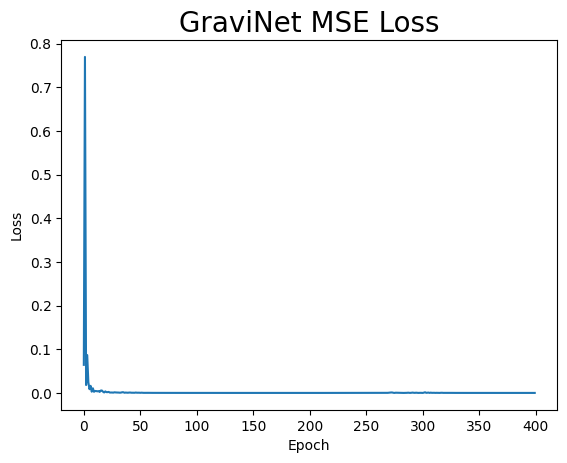

In [27]:
plot_loss(losses)

By plotting the error our model made, we can see how fast our model learns to simulate the given system.

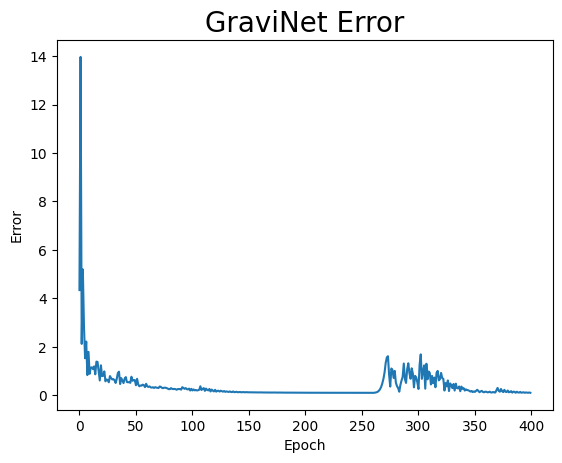

In [28]:
plot_error(errors)

Lastly, this snippet of code runs a pygame simulation that draws out the movement of the simulated bodies that our model predicts with rollout.

In [29]:
objects = dataset[0].unsqueeze(0)
@torch.no_grad()
def update_func():
    global objects
    predicted = model(objects, edge_index)

    objects[0, :, (dimension + 1):] = predicted
    objects[0, :, 1:(dimension + 1)] += objects[0, :, (dimension + 1):] * dt
    draw = []
    for i in range(objects.shape[1]):
        curr = list(objects[0, i, 1:(dimension + 1)]) + [0] if dimension == 2 else list(objects[0, i, 1:(dimension + 1)])
        draw.append(curr)
    return draw

app = PygApp(update_func)

: 

Sadly, closing the pygame window doesn't work and forcefully closing it causes the kernel to crash.

### Conclusion

Trying to solve the N-body problem with Graph Neural Networks proved to be both a fascinating and exceptionally challenging task. Our exploration highlighted the need for further research to uncover more effective models, since learning numerical integrators is no easy feat for regular Graph Neural Networks.

We hope you enjoyed reading our Notebook on this topic and we hope that you found it engaging. In it, we showcased two GNN architectures: IGN and GraviNet. While IGN demonstrated its ability to model simple rotations, it fell short on more complex tasks. We also presented GraviNet and its capability to handle slightly more intricate systems. It is, however, important to emphasize that GraviNet is a long ways away from being useful in the real world. Tho it has shown that it has potential. This makes us believe that Graph Neural Networks will become even more widespread in physics in the coming years as this is only one of the many possible real-world applications in which GNNs can be used.

If you are interested in additional information regarding the GraviNet model, we invite you to read our Medium *[post](https://medium.com/@petjafurlan/simulating-gravity-with-graph-neural-networks-d3be57abf60f)*. We appreciate your time and interest. Thanks for reading!